# 5회차 실습 과제

## 문제 항목

| 문제     | 주제                                       | 핵심 학습 포인트                              |
|----------|--------------------------------------------|-----------------------------------------------|
| 문제 1   | 3개 공장의 배터리 수명 비교 (ANOVA)        | 가정 검정 → 검정 선택 → 사후검정 → 효과크기   |
| 문제 2   | 직원 데이터 상관분석                       | Pearson vs Spearman, 산점도, 상관 vs 인과      |
| 문제 3   | 앱 UI 변경 A/B 테스트 (전환율)             | 실험 설계 → 표본 크기 산정 → 검정 → 의사결정   |
| 문제 4   | 학습 앱 A/B 테스트 (연속형 지표)           | 연속형 A/B 테스트, CLT, 모수 vs 비모수         |

In [1]:
# 필수 라이브러리 Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize, proportion_confint, confint_proportions_2indep
from statsmodels.stats.power import NormalIndPower
from scipy.stats import skew
import seaborn as sns
import warnings
import platform

warnings.filterwarnings('ignore')

# 운영체제별 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

print("=" * 60)
print("5회차 실습 과제")
print("=" * 60)

5회차 실습 과제


---

## 문제 1: 3개 공장의 배터리 수명 비교 (ANOVA)

전자제품 회사에서 3개 공장(A, B, C)에서 생산한 배터리의 수명(시간)이 동일한지 검증합니다.
각 공장에서 20개씩 배터리를 무작위로 추출하여 수명을 측정했습니다.

**분석 목표**: 3개 공장에서 생산한 배터리의 평균 수명에 통계적으로 유의한 차이가 있는지 검정합니다.

**주어진 데이터:**

In [2]:
print("\n[문제 1] 3개 공장의 배터리 수명 비교")
print("=" * 50)

np.random.seed(691)
factory_a = np.round(np.random.normal(loc=480, scale=30, size=20), 1)   # A공장: 평균 480시간
factory_b = np.round(np.random.normal(loc=510, scale=25, size=20), 1)   # B공장: 평균 510시간
factory_c = np.round(np.random.normal(loc=495, scale=35, size=20), 1)   # C공장: 평균 495시간

for name, data in [('A공장', factory_a), ('B공장', factory_b), ('C공장', factory_c)]:
    print(f"  {name} (n={len(data)}): 평균={data.mean():.1f}시간, SD={data.std(ddof=1):.1f}시간")


[문제 1] 3개 공장의 배터리 수명 비교
  A공장 (n=20): 평균=467.4시간, SD=20.0시간
  B공장 (n=20): 평균=519.5시간, SD=23.9시간
  C공장 (n=20): 평균=500.1시간, SD=25.6시간


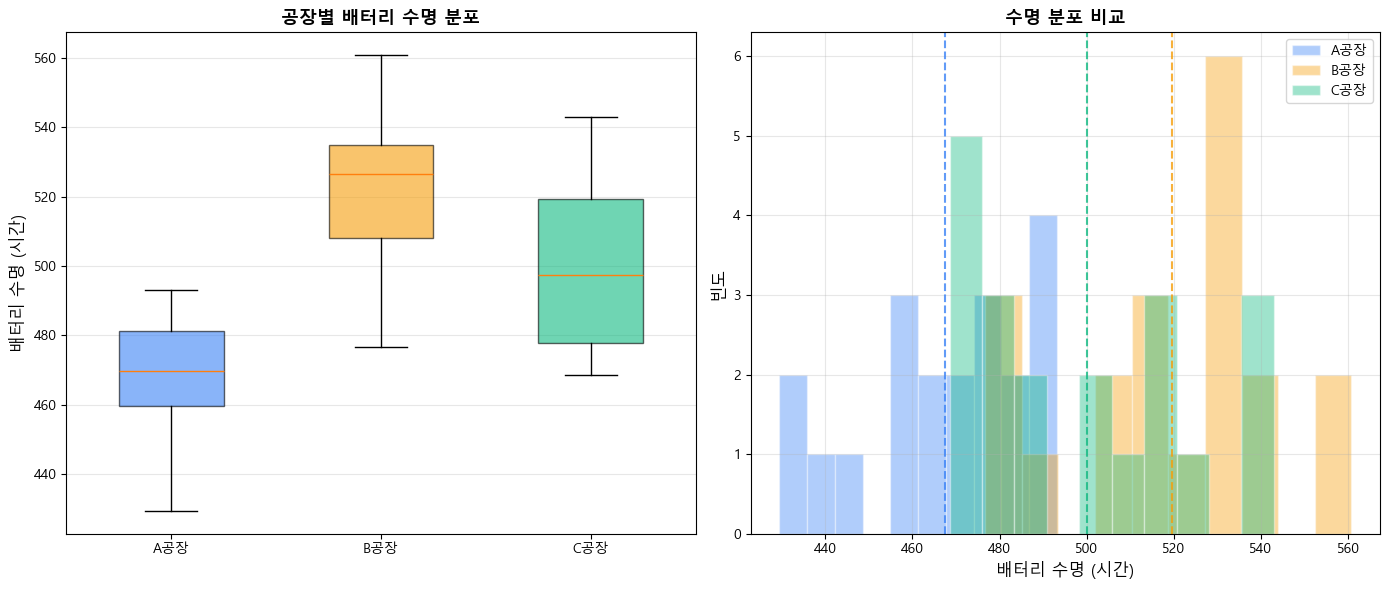

In [3]:
# 분포 시각화: 박스플롯 + 히스토그램
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#3B82F6', '#F59E0B', '#10B981']
bp = axes[0].boxplot([factory_a, factory_b, factory_c],
                      labels=['A공장', 'B공장', 'C공장'],
                      patch_artist=True, widths=0.5)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[0].set_ylabel('배터리 수명 (시간)', fontsize=12)
axes[0].set_title('공장별 배터리 수명 분포', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for data, name, color in [(factory_a, 'A공장', '#3B82F6'),
                           (factory_b, 'B공장', '#F59E0B'),
                           (factory_c, 'C공장', '#10B981')]:
    axes[1].hist(data, bins=10, alpha=0.4, color=color, edgecolor='white', label=name)
    axes[1].axvline(data.mean(), color=color, linestyle='--', alpha=0.8)

axes[1].set_xlabel('배터리 수명 (시간)', fontsize=12)
axes[1].set_ylabel('빈도', fontsize=12)
axes[1].set_title('수명 분포 비교', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 1-1: 가설 설정 및 가정 검정

**(a)** 분석 목표에 맞는 **귀무가설(H₀)** 과 **대립가설(H₁)** 을 수식으로 설정하세요.

**(b)** 각 공장 데이터의 **정규성 검정**(Shapiro-Wilk)을 수행하세요.

**(c)** 3개 공장의 **Q-Q Plot**을 나란히 그리세요.

**(d)** 정규성이 충족된다면, **등분산 검정**(Levene)을 수행하세요.

**(e)** 가정 검정 결과를 종합하여 **어떤 검정을 사용할지** 결정하세요.
의사결정 과정을 단계별로 설명하세요.

> **의사결정 흐름**: 정규성 확인 → (충족 시) 등분산 확인 → 검정 방법 선택

In [4]:
print("\n[문제 1-1] 가설 설정 및 가정 검정")
print("-" * 40)

# TODO (a): 가설 설정
print("귀무가설(H0): mu_A = mu_B = mu_C")
print("대립가설(H1): ~H0")

# TODO (b): 정규성 검정 (각 공장별)
for name, data in [('A공장', factory_a), ('B공장', factory_b), ('C공장', factory_c)]:
    stat, p = stats.shapiro(data)
    print(f"{name} 정규성 검정: W={stat:.3f}, p={p:.3f} -> {'정규성 만족' if p > 0.05 else '정규성 불만족'}")


[문제 1-1] 가설 설정 및 가정 검정
----------------------------------------
귀무가설(H0): mu_A = mu_B = mu_C
대립가설(H1): ~H0
A공장 정규성 검정: W=0.921, p=0.104 -> 정규성 만족
B공장 정규성 검정: W=0.933, p=0.175 -> 정규성 만족
C공장 정규성 검정: W=0.906, p=0.054 -> 정규성 만족


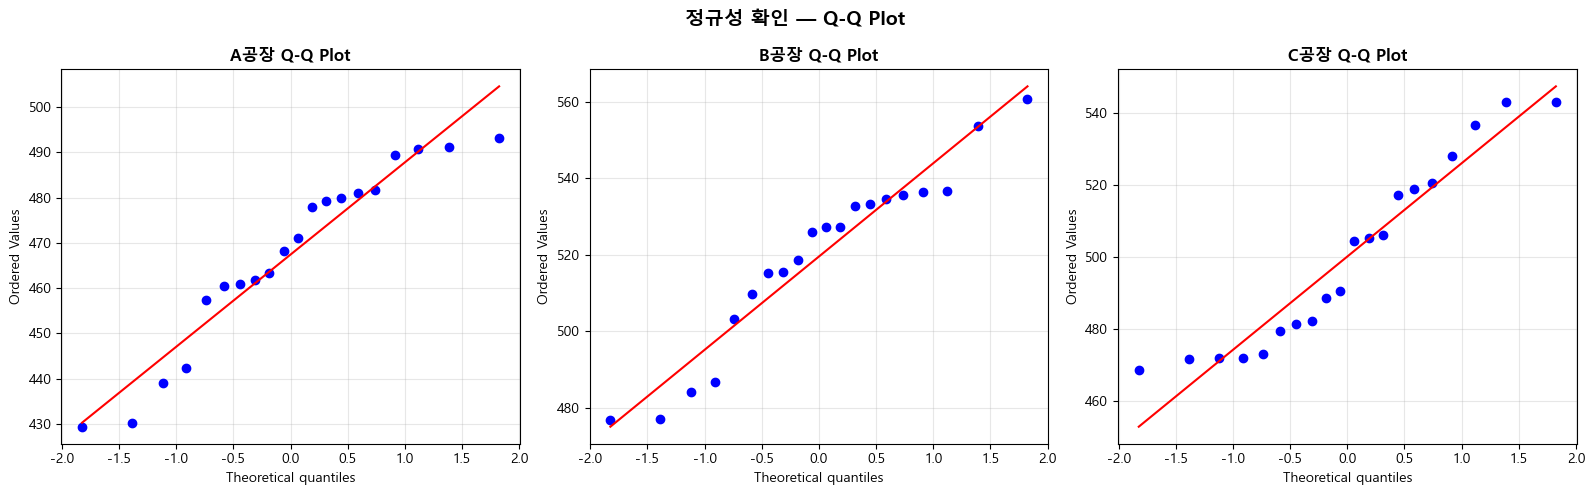

In [5]:
# TODO (c): Q-Q Plot (3개 공장)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("정규성 확인 — Q-Q Plot", fontsize=14, fontweight='bold')

# TODO: 각 공장의 Q-Q Plot 그리기
for ax, data, name, color in [(axes[0], factory_a, 'A공장', '#3B82F6'),
                                (axes[1], factory_b, 'B공장', '#F59E0B'),
                                (axes[2], factory_c, 'C공장', '#10B981')]:
    stats.probplot(data, dist="norm", plot=ax)
    ax.set_title(f"{name} Q-Q Plot", fontsize=12, fontweight="bold")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# TODO (d): 등분산 검정 (정규성 충족 시)
lev_stat, lev_p = stats.levene(factory_a, factory_b, factory_c)
# TODO (e): 검정 방법 결정
if lev_p is not None and lev_p > 0.05:
    print("등분산 가정 충족: one-way ANOVA 사용")
    equal_var = True
else:
    print("등분산 가정 불충족: Welch's ANOVA 사용")
    equal_var = False

등분산 가정 충족: one-way ANOVA 사용


### 문제 1-2: ANOVA 검정 수행 및 효과크기

**(a)** 1-1에서 결정한 검정을 수행하세요 (α = 0.05).

**(b)** 전체 효과크기(η² 또는 η²_H)를 계산하고 해석하세요.

**(c)** ω²(오메가제곱)을 계산할 수 있다면 함께 보고하세요.

**(d)** 검정 결과(p-value)와 효과크기를 종합하여 결론을 내리세요.

In [7]:
print("\n[문제 1-2] ANOVA 검정 수행 및 효과크기")
print("-" * 40)

# 표본 데이터 생성
groups = ['A공장'] * 20 + ['B공장'] * 20 + ['C공장'] * 20
lifetimes = np.concatenate([factory_a, factory_b, factory_c])
df_battery = pd.DataFrame({'공장': groups, '수명': lifetimes})

print("배터리 데이터 샘플:")
display(df_battery.sample(5))
print("기술통계:")
display(df_battery.describe().round(2))


[문제 1-2] ANOVA 검정 수행 및 효과크기
----------------------------------------
배터리 데이터 샘플:


,공장,수명
52,C공장,506.1
43,C공장,505.3
32,B공장,486.8
21,B공장,536.4
33,B공장,526.0


기술통계:


,수명
count,60.00
mean,495.69
std,31.50
min,429.40
25%,472.72
50%,490.05
75%,521.88
max,560.80


In [8]:
# TODO (a): 검정 수행
aov = pg.anova(dv='수명', between='공장', data=df_battery, detailed=True)
display(aov)

# TODO (b): 전체 효과크기 
eta_sq = aov['np2'].values[0]
print(f"η² (에타제곱) = {eta_sq:.4f}")

# TODO (c): ω² (적절한 검정인 경우)
ss_b = aov['SS'].values[0]
ss_w = aov['SS'].values[1]
df_b = aov['DF'].values[0]
ms_w = aov['MS'].values[1]

ss_t = ss_b + ss_w
omega_sq = (ss_b - df_b * ms_w) / (ss_t + ms_w)
print(f"ω² (오메가제곱) = {omega_sq:.4f}")

# TODO (d): 종합 결론
if aov['p-unc'].values[0] is not None:
    verdict = 'H₀ 기각: 적어도 하나의 집단 평균이 다릅니다' if aov['p-unc'].values[0] < 0.05 else 'H₀ 기각 실패: 집단 평균이 모두 같다고 볼 수 있습니다'
    print(f"판정 (α=0.05): {verdict}")

if eta_sq is not None:
    size_eta = '작은' if eta_sq < 0.06 else '중간' if eta_sq < 0.14 else '큰'
    print(f"[효과크기] η² = {eta_sq:.4f} ({size_eta} 효과)")
    print(f"  해석: 0.01 작은, 0.06 중간, 0.14 큰")

,Source,SS,DF,MS,F,p-unc,np2
0,공장,27712.356333,2,13856.178167,25.619021,1.155063e-08,0.473383
1,Within,30828.741000,57,540.855105,NaN,NaN,NaN


η² (에타제곱) = 0.4734
ω² (오메가제곱) = 0.4507
판정 (α=0.05): H₀ 기각: 적어도 하나의 집단 평균이 다릅니다
[효과크기] η² = 0.4734 (큰 효과)
  해석: 0.01 작은, 0.06 중간, 0.14 큰


### 문제 1-3: 사후검정 — 어떤 공장 쌍이 다른가?

ANOVA가 유의하다면, **"적어도 하나가 다르다"** 는 것만 알 수 있습니다.
**어떤 공장 쌍**이 다른지 확인하려면 사후검정이 필요합니다.

**(a)** 사용한 검정 방법에 맞는 사후검정을 수행하세요.

> | 검정 방법 | 사후검정 |
> |-----------|---------|
> | One-way ANOVA | Tukey HSD |
> | Welch's ANOVA | Games-Howell |
> | Kruskal-Wallis | Dunn 검정 (Bonferroni 보정) |

**(b)** 쌍별 효과크기를 계산하세요.

> - Tukey HSD 후 → Cohen's d (`pg.compute_effsize(x, y, eftype='cohen')`)
> - Games-Howell 후 → Hedges' g (`pg.compute_effsize(x, y, eftype='hedges')`)
> - Dunn 검정 후 → 중앙값 차이로 방향과 크기 해석

**(c)** 사후검정 결과를 종합하여, 구체적으로 어떤 공장이 어떻게 다른지 해석하세요.

**(d)** 공장별 평균 배터리 수명을 막대 그래프(±SEM 오차막대 포함)로 시각화하세요.

In [9]:
print("\n[문제 1-3] 사후검정")
print("-" * 40)

# TODO (a): 사후검정 수행
tukey = pairwise_tukeyhsd(df_battery['수명'], df_battery['공장'], alpha=0.05)
print(tukey)
# TODO (b): 쌍별 효과크기
group_data = {'공장 a': factory_a, '공장 b': factory_b, '공장 c': factory_c}
for (group_name1, group_data1), (group_name2, group_data2) in combinations(group_data.items(), 2):
    d = pg.compute_effsize(group_data1, group_data2, eftype='cohen')
    size_d = '매우 작은' if abs(d) < 0.2 else '작은' if abs(d) < 0.5 else '중간' if abs(d) < 0.8 else '큰'
    print(f"{group_name1} vs {group_name2}: d = {d:.4f} ({size_d} 효과)")
# TODO (c): 종합 해석
print("A < C < B순으로 성능이 좋다.")


[문제 1-3] 사후검정
----------------------------------------
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   A공장    B공장   52.085    0.0  34.3875 69.7825   True
   A공장    C공장    32.66 0.0001  14.9625 50.3575   True
   B공장    C공장  -19.425 0.0283 -37.1225 -1.7275   True
-----------------------------------------------------
공장 a vs 공장 b: d = -2.3671 (큰 효과)
공장 a vs 공장 c: d = -1.4231 (큰 효과)
공장 b vs 공장 c: d = 0.7854 (중간 효과)
A < C < B순으로 성능이 좋다.


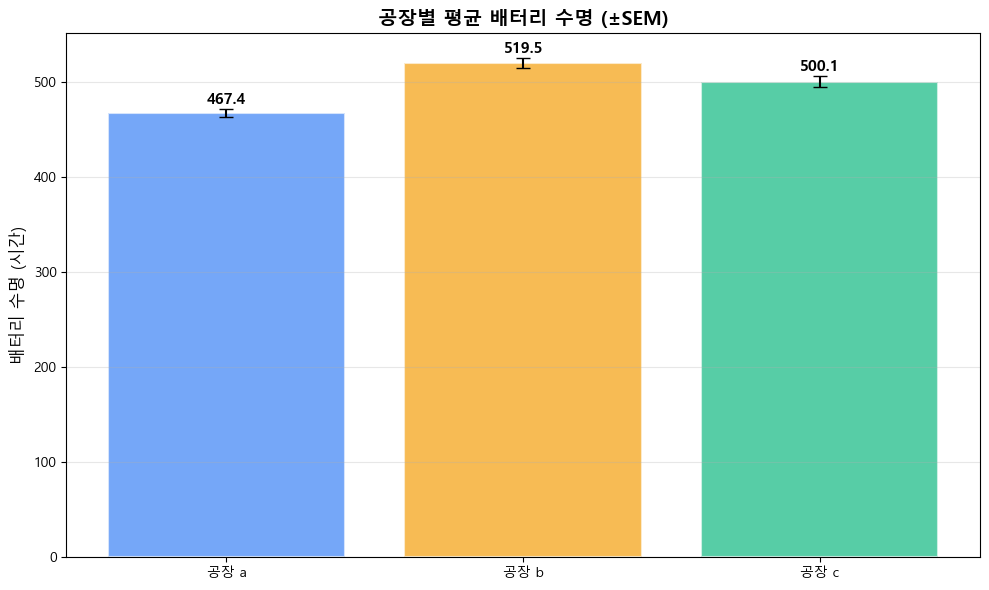

In [10]:
# TODO (d): 막대 그래프 (±SEM)
fig, ax = plt.subplots(figsize=(10, 6))

means = [d.mean() for d in group_data.values()]
sems = [d.std(ddof=1) / np.sqrt(len(d)) for d in group_data.values()]

# TODO: 막대 그래프 + 오차막대 + 평균값 텍스트 표시
bars = ax.bar(group_data.keys(), means, yerr=sems, capsize=5,
        color=colors, alpha=0.7, edgecolor='white', linewidth=1.5)
for bar, mean, sem in zip(bars, means, sems):
     ax.text(bar.get_x() + bar.get_width()/2., mean + sem + 1,
             f'{mean:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('배터리 수명 (시간)', fontsize=12)
ax.set_title('공장별 평균 배터리 수명 (±SEM)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---

## 문제 2: 직원 데이터 상관분석

한 IT 기업에서 직원 30명의 데이터를 수집했습니다.
경력(년), 월급여(만원), 프로젝트 완료 수, 직무 만족도(1~10점)의 관계를 분석합니다.

**분석 목표**:
- 변수 간 상관관계를 파악하고, 어떤 변수 쌍이 유의한 상관을 보이는지 확인합니다.
- Pearson과 Spearman 상관계수를 비교하여 데이터의 특성을 파악합니다.

**주어진 데이터:**

In [11]:
print("\n[문제 2] 직원 데이터 상관분석")
print("=" * 50)

np.random.seed(552)
n_emp = 30

experience = np.round(np.random.uniform(1, 15, n_emp), 1)
salary = np.round(2500 + 180 * experience + np.random.normal(0, 400, n_emp), 0)
projects = np.round(np.clip(2 + 0.8 * experience + np.random.normal(0, 3, n_emp), 0, 30), 0).astype(int)
satisfaction = np.round(np.clip(4 + 0.3 * experience - 0.0005 * salary + np.random.normal(0, 1.8, n_emp), 1, 10), 1)

df_emp = pd.DataFrame({
    '경력(년)': experience,
    '월급여(만원)': salary,
    '프로젝트수': projects,
    '만족도': satisfaction
})
print("직원 데이터 샘플:")
display(df_emp.sample(5))
print("기술통계:")
display(df_emp.describe().round(2))


[문제 2] 직원 데이터 상관분석
직원 데이터 샘플:


,경력(년),월급여(만원),프로젝트수,만족도
23,8.7,4354.0,15,6.3
3,12.2,4357.0,11,6.9
15,8.8,4159.0,11,5.3
24,5.8,2343.0,5,8.6
4,3.8,3216.0,3,4.1


기술통계:


,경력(년),월급여(만원),프로젝트수,만족도
count,30.00,30.00,30.00,30.00
mean,8.69,3973.30,9.03,4.49
std,4.07,871.03,4.86,2.04
min,1.80,2094.00,0.00,1.00
25%,5.72,3248.00,6.00,3.02
50%,8.75,4045.00,8.50,4.05
75%,12.15,4703.50,13.75,6.20
max,14.60,5378.00,19.00,8.60


### 문제 2-1: 산점도와 상관 행렬

**(a)** `경력(년)`과 `월급여(만원)`의 산점도를 그리고, 회귀선을 추가하세요.
시각적으로 어떤 관계가 보이는지 서술하세요.

**(b)** 전체 변수의 **Pearson 상관 행렬**을 계산하고 히트맵으로 시각화하세요.

> `df_emp.corr(method='pearson')` + `seaborn.heatmap()`

**(c)** 전체 변수의 **Spearman 상관 행렬**도 함께 히트맵으로 그려서 나란히 비교하세요.


[문제 2-1] 산점도와 상관 행렬
----------------------------------------


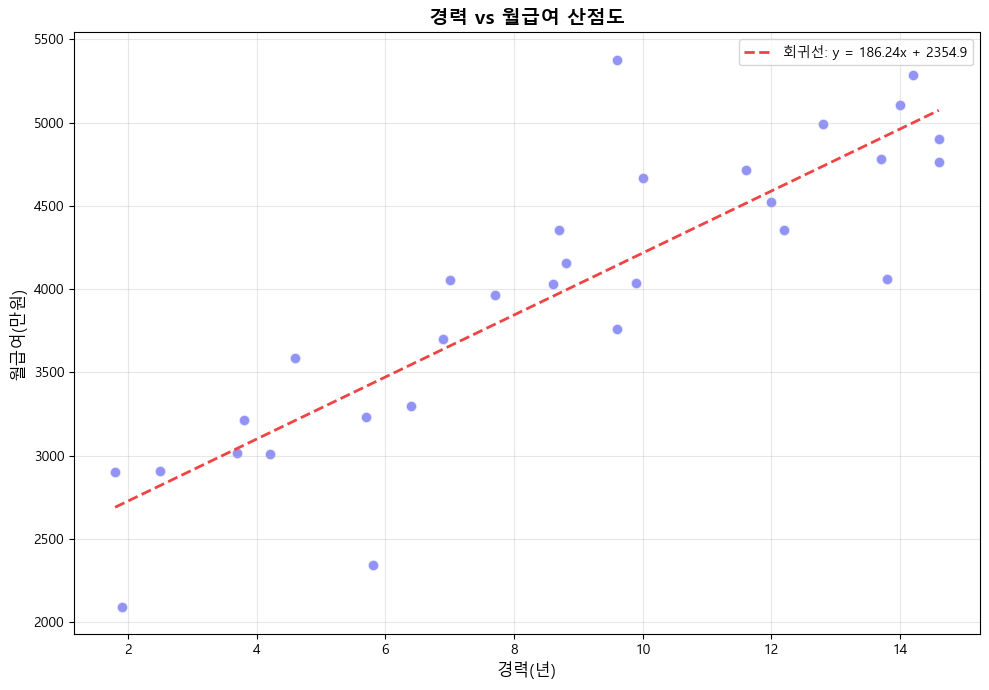

(a) 시각적 관찰 결과 해석:
    양의 선형관계를 보이며, 선형적 관계가 존재할 것으로 예상된다. 이상치도 중간중간 존재하는걸로 보인다.


In [12]:
print("\n[문제 2-1] 산점도와 상관 행렬")
print("-" * 40)

# TODO (a): 경력 vs 월급여 산점도 + 
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(experience, salary, color='#6366F1', alpha=0.7, s=60, edgecolors='white')

# 회귀선 추가
z = np.polyfit(experience, salary, 1)
p = np.poly1d(z)
x_line = np.linspace(experience.min(), experience.max(), 100)
ax.plot(x_line, p(x_line), color='#EF4444', linewidth=2, linestyle='--',
        label=f'회귀선: y = {z[0]:.2f}x + {z[1]:.1f}')

ax.set_xlabel('경력(년)', fontsize=12)
ax.set_ylabel('월급여(만원)', fontsize=12)
ax.set_title('경력 vs 월급여 산점도', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("(a) 시각적 관찰 결과 해석:")
print(f"    양의 선형관계를 보이며, 선형적 관계가 존재할 것으로 예상된다. 이상치도 중간중간 존재하는걸로 보인다.")

Text(0.5, 1.0, 'Spearman 상관 행렬')

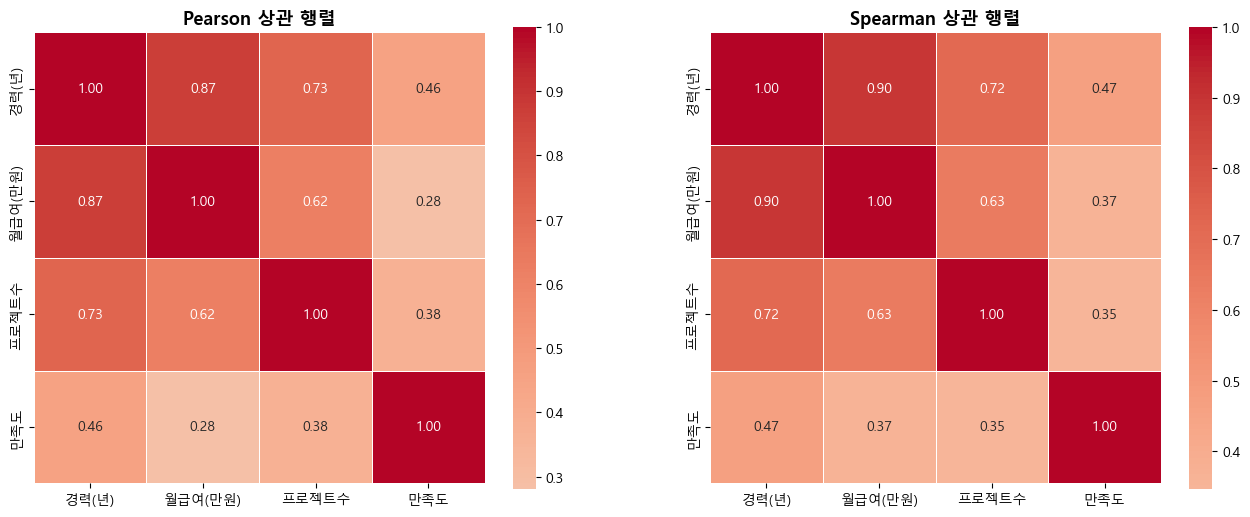

In [13]:
# Pearson vs Spearman 상관 히트맵
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# TODO (b): Pearson 상관 행렬 히트맵
pearson_corr = df_emp.corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, ax=axes[0])
axes[0].set_title('Pearson 상관 행렬', fontsize=13, fontweight='bold')
# TODO (c): Spearman 상관 행렬 히트맵
spearman_corr = df_emp.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, ax=axes[1])
axes[1].set_title('Spearman 상관 행렬', fontsize=13, fontweight='bold')

### 문제 2-2: 상관계수 가설검정

**(a)** `경력(년)`과 `월급여(만원)` 사이의 **Pearson 상관계수**와 **p-value**를 구하세요.

**(b)** 같은 변수 쌍에 대해 **Spearman 상관계수**와 **p-value**를 구하세요.

**(c)** 두 상관계수를 비교하세요. 차이가 크다면/작다면 어떤 의미인지 설명하세요.

In [14]:
print("\n[문제 2-2] 상관계수 가설검정")
print("-" * 40)

# TODO (a): Pearson 상관계수
r_pearson, p_pearson = stats.pearsonr(df_emp['경력(년)'], df_emp['월급여(만원)'])
if r_pearson is not None:
    size_r = '약한' if abs(r_pearson) < 0.3 else '중간' if abs(r_pearson) < 0.7 else '강한'
    direction = '양의' if r_pearson > 0 else '음의'
    print(f"  r = {r_pearson:.4f} ({size_r} {direction} 상관)")
    print(f"  p = {p_pearson:.4f}")
    sig_p = '유의한 상관 (p < 0.05)' if p_pearson < 0.05 else '유의하지 않음 (p ≥ 0.05)'
    print(f"  판정: {sig_p}")

    print(f"\n  결정계수 r² = {r_pearson**2:.4f}")
    print(f"  경력이 월급여 분산의 {r_pearson**2*100:.1f}%를 설명합니다")

# TODO (b): Spearman 상관계수
r_spearman, p_spearman = stats.spearmanr(df_emp['경력(년)'], df_emp['월급여(만원)'])
if r_spearman is not None:
    size_rs = '약한' if abs(r_spearman) < 0.3 else '중간' if abs(r_spearman) < 0.7 else '강한'
    direction_s = '양의' if r_spearman > 0 else '음의'
    print(f"  ρ = {r_spearman:.4f} ({size_rs} {direction_s} 상관)")
    print(f"  p = {p_spearman:.4f}")
    sig_sp = '유의한 상관 (p < 0.05)' if p_spearman < 0.05 else '유의하지 않음 (p ≥ 0.05)'
    print(f"  판정: {sig_sp}")

# TODO (c): 비교
print(f"\n(c) Pearson vs Spearman 비교:")
print(f"    차이: Pearson r = {r_pearson:.4f} vs Spearman ρ = {r_spearman:.4f}")
print(f"    해석: 두 상관계수 모두 유의한 양의 상관을 보이며, 값도 유사하여 선형적 관계가 존재한다고 볼 수 있다.")


[문제 2-2] 상관계수 가설검정
----------------------------------------
  r = 0.8701 (강한 양의 상관)
  p = 0.0000
  판정: 유의한 상관 (p < 0.05)

  결정계수 r² = 0.7571
  경력이 월급여 분산의 75.7%를 설명합니다
  ρ = 0.8965 (강한 양의 상관)
  p = 0.0000
  판정: 유의한 상관 (p < 0.05)

(c) Pearson vs Spearman 비교:
    차이: Pearson r = 0.8701 vs Spearman ρ = 0.8965
    해석: 두 상관계수 모두 유의한 양의 상관을 보이며, 값도 유사하여 선형적 관계가 존재한다고 볼 수 있다.


### 문제 2-3: 다변량 상관분석과 해석

**(a)** `pg.pairwise_corr(df_emp, method='pearson')`으로 모든 변수 쌍의 상관분석을 수행하세요.
유의한 상관(p < 0.05)을 보이는 쌍을 모두 찾으세요.

**(b)** 유의한 상관을 보이는 변수 쌍 중에서, **상관이 인과를 의미하지 않는** 예시를 하나 들고,
왜 인과라고 할 수 없는지 교란변수의 가능성을 포함하여 설명하세요.

> **상관 vs 인과**: 두 변수가 함께 움직여도(상관), 한 변수가 다른 변수를 변화시킨다(인과)고
> 단정할 수 없습니다. 인과를 확인하려면 **실험(RCT, A/B 테스트)** 이 필요합니다.

**(c)** 만약 `경력`과 `만족도` 사이에 유의한 상관이 있다면,
"경력이 많을수록 만족도가 높다"고 결론 내릴 수 있나요?
왜 그런지/아닌지 교란변수(예: 직급, 급여, 업무 환경)의 관점에서 논의하세요.

In [15]:
print("\n[문제 2-3] 다변량 상관분석과 해석")
print("-" * 40)

# TODO (a): pairwise_corr
pearson_result = pg.pairwise_corr(df_emp, method='pearson')
display(pearson_result[pearson_result['p-unc'] < 0.05])

# TODO (b): 상관 vs 인과 — 교란변수 논의
print("아이스크림의 매출량이 증가하면 익사률이 올라간다.")
print("아이스크림과 익사률은 여름이라는 교란변수로 인해 상관관계가 있지, 인과관계가 있다고 보기는 어렵다.")

# TODO (c): 경력 vs 만족도 해석
print("경력과 만족도는 약한 양의 상관이 존재하지만, 월급여와의 관계에서 교란변수 역할을 할 수 있다.")


[문제 2-3] 다변량 상관분석과 해석
----------------------------------------


,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,경력(년),월급여(만원),pearson,two-sided,30,0.870138,"[0.74, 0.94]",4.220485e-10,2.496e+07,1.000000
1,경력(년),프로젝트수,pearson,two-sided,30,0.731927,"[0.5, 0.86]",4.297150e-06,5280.265,0.998403
2,경력(년),만족도,pearson,two-sided,30,0.456776,"[0.12, 0.7]",1.116697e-02,4.899,0.738737
3,월급여(만원),프로젝트수,pearson,two-sided,30,0.620774,"[0.34, 0.8]",2.520477e-04,134.422,0.968911
5,프로젝트수,만족도,pearson,two-sided,30,0.376189,"[0.02, 0.65]",4.047426e-02,1.683,0.549764


아이스크림의 매출량이 증가하면 익사률이 올라간다.
아이스크림과 익사률은 여름이라는 교란변수로 인해 상관관계가 있지, 인과관계가 있다고 보기는 어렵다.
경력과 만족도는 약한 양의 상관이 존재하지만, 월급여와의 관계에서 교란변수 역할을 할 수 있다.


---

## 문제 3: 앱 UI 변경 A/B 테스트 (전환율 비교)

모바일 쇼핑 앱에서 결제 화면 UI를 개선하면 **구매 전환율**이 높아지는지 A/B 테스트를 수행합니다.

- **대조군(A)**: 기존 결제 화면
- **실험군(B)**: 개선된 결제 화면 (버튼 크기 확대 + 단계 축소)
- **지표**: 구매 전환율 (결제 완료 비율)
- **현재 전환율**: 8%
- **비즈니스 목표**: 최소 2%p 이상 개선을 탐지하고 싶음 (8% → 10%)

**분석 목표**: 개선된 UI가 기존 대비 전환율을 유의하게 높이는지 검정합니다.

---

### 문제 3-1: 실험 설계 — 표본 크기 산정

A/B 테스트를 실행하기 **전에** 필요한 표본 크기를 산정합니다.

**(a)** 실험 설계 파라미터를 정리하세요.

**(b)** **효과크기(Cohen's h)** 를 계산하세요.

**(c)** **집단당 필요 표본 크기**를 산정하세요.

**(d)** 양측검정과 단측검정 각각에 대해 표본 크기를 구하고, 차이를 비교하세요.
이 실험에서는 어떤 검정이 더 적절한지 근거와 함께 설명하세요.

In [16]:
print("\n[문제 3] 앱 UI 변경 A/B 테스트")
print("=" * 50)
print("\n[문제 3-1] 실험 설계 — 표본 크기 산정")
print("-" * 40)

baseline_rate = 0.08   # 기존 전환율
mde = 0.02             # 최소 탐지 효과 (2%p)
alpha = 0.05           # 유의수준
power_target = 0.80    # 검정력

# TODO (a): 파라미터 정리
baseline_rate = 0.08   # 기존 전환율
mde = 0.02             # 최소 탐지 효과 (2%p)
alpha = 0.05           # 유의수준
power_target = 0.80    # 검정력

# TODO (b): 효과크기 (Cohen's h)
effect_size = abs(proportion_effectsize(baseline_rate + mde, baseline_rate))
if effect_size is not None:
    print(f"효과크기 (Cohen's h) = {effect_size:.4f}")

# TODO (c): 필요 표본 크기
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power_target,
    alternative='two-sided'
)
if sample_size is not None:
    sample_size = int(np.ceil(sample_size))
    print(f"\n집단당 필요 표본 크기(양측): {sample_size:,}명")
    print(f"총 필요 표본 크기: {sample_size * 2:,}명")


# TODO (d): 양측 vs 단측 비교 및 선택

sample_size_1tailed = int(np.ceil(power_analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power_target,
    alternative='larger')))

print(f"\n집단당 필요 표본 크기 (단측): {sample_size_1tailed:,}명")
print("\n하락 리스크 탐지를 위해서 양측 검정 선택")


[문제 3] 앱 UI 변경 A/B 테스트

[문제 3-1] 실험 설계 — 표본 크기 산정
----------------------------------------
효과크기 (Cohen's h) = 0.0700

집단당 필요 표본 크기(양측): 3,205명
총 필요 표본 크기: 6,410명

집단당 필요 표본 크기 (단측): 2,525명

하락 리스크 탐지를 위해서 양측 검정 선택


### 문제 3-2: A/B 테스트 실행 및 검정

실험을 진행하여 아래 데이터를 수집했습니다.

**(a)** 각 집단의 전환율을 계산하세요.

**(b)** **z-비율검정**을 수행하세요.

> `proportions_ztest(count, nobs, alternative=...)`

**(c)** **효과크기(Cohen's h)** 를 관측된 전환율로 계산하세요.

**(d)** 각 집단의 **95% 신뢰구간**을 구하세요.

> `proportion_confint(count, nobs, alpha=0.05, method='wilson')`

**(e)** **비율 차이의 95% 신뢰구간**을 구하세요.

> `confint_proportions_2indep(count1, nobs1, count2, nobs2, method='wald')`

**(f)** **상대적 개선율(Relative Lift)** 을 계산하세요.

> 상대적 개선율 = (실험군 전환율 − 대조군 전환율) / 대조군 전환율 × 100

**(g)** 전환율 비교 막대 그래프를 그리세요 (95% 신뢰구간 포함).

In [17]:
print("\n[문제 3-2] A/B 테스트 실행 및 검정")
print("-" * 40)

np.random.seed(553)
n_per_group = 2600  # 실험에 참여한 인원 (집단당)

# 데이터 생성 (시뮬레이션)
control_conv = np.random.binomial(1, 0.08, n_per_group)    # 대조군: 8%
treatment_conv = np.random.binomial(1, 0.105, n_per_group)  # 실험군: 10.5%

# TODO (a): 전환율 계산
control_rate = control_conv.mean()
treatment_rate = treatment_conv.mean()

if control_rate is not None and treatment_rate is not None:
    print(f"대조군 전환율: {control_conv.sum():,}/{n_per_group:,} = {control_rate:.4f} ({control_rate:.2%})")
    print(f"실험군 전환율: {treatment_conv.sum():,}/{n_per_group:,} = {treatment_rate:.4f} ({treatment_rate:.2%})")

# TODO (b): z-비율검정
count = np.array([treatment_conv.sum(), control_conv.sum()])
nobs = np.array([n_per_group, n_per_group])

z_stat, z_p = proportions_ztest(count, nobs, alternative='larger')
print(f" z 통계량: {z_stat:.4f}")
print(f" p-value: {z_p:.4f}")

# TODO (c): 관측된 효과크기 (Cohen's h)
h = proportion_effectsize(control_rate, treatment_rate)
size_h = '매우 작은' if abs(h) < 0.2 else '작은' if abs(h) < 0.5 else '중간' if abs(h) < 0.8 else '큰'
print(f"\n  [효과크기] Cohen's h = {abs(h):.4f} ({size_h} 효과)")

# TODO (d): 실험군, 대조군 95% 신뢰구간
ci_treatment = proportion_confint(count[0], nobs[0], alpha=0.05, method='wilson')
ci_control = proportion_confint(count[1], nobs[1], alpha=0.05, method='wilson')
print(f"\n  실험군 95% 신뢰구간: [{ci_treatment[0]:.4f}, {ci_treatment[1]:.4f}]")
print(f"  대조군 95% 신뢰구간: [{ci_control[0]:.4f}, {ci_control[1]:.4f}]")

# TODO (e): 비율 차이의 95% 신뢰구간
ci_low, ci_upp = confint_proportions_2indep(
    count[0], nobs[0],   # treatment: 성공 수, 표본 크기
    count[1], nobs[1],   # control: 성공 수, 표본 크기
    method='wald'        # method: 'wald'(정규근사, 대표본), 'newcombe'(Wilson 기반, 소표본 디폴트 값),
)
print(f"\n  95% 신뢰구간: [{ci_low:.4f}, {ci_upp:.4f}]")

# TODO (f): 상대적 개선율
relative_lift = (treatment_rate - control_rate) / control_rate * 100
print(f" 상대적 개선율: {relative_lift:+.1f}%")


[문제 3-2] A/B 테스트 실행 및 검정
----------------------------------------
대조군 전환율: 216/2,600 = 0.0831 (8.31%)
실험군 전환율: 289/2,600 = 0.1112 (11.12%)
 z 통계량: 3.4187
 p-value: 0.0003

  [효과크기] Cohen's h = 0.0951 (매우 작은 효과)

  실험군 95% 신뢰구간: [0.0996, 0.1238]
  대조군 95% 신뢰구간: [0.0731, 0.0943]

  95% 신뢰구간: [0.0120, 0.0442]
 상대적 개선율: +33.8%


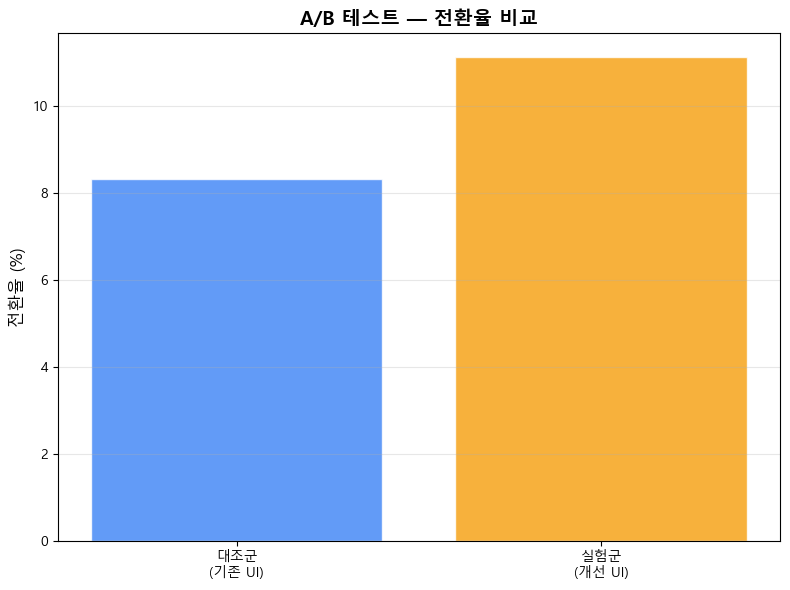

In [18]:
# TODO (g): 전환율 비교 막대 그래프 (신뢰구간 포함)
fig, ax = plt.subplots(figsize=(8, 6))

# TODO: 막대 그래프 그리기
labels = ['대조군\n(기존 UI)', '실험군\n(개선 UI)']
rates = [control_rate * 100, treatment_rate * 100]
bar_colors = ['#3B82F6', '#F59E0B']
bars = ax.bar(labels, rates, color=bar_colors, alpha=0.8, edgecolor='white')
# ... (오차막대, 텍스트 추가)

ax.set_ylabel('전환율 (%)', fontsize=12)
ax.set_title('A/B 테스트 — 전환율 비교', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 3-3: 비즈니스 의사결정

**(a)** A/B 테스트 결과를 종합하여, UI 변경을 **전체 사용자에게 적용할지** 의사결정을 내리세요.
아래 항목을 모두 포함하여 보고서 형식으로 작성하세요.

> | 항목 | 내용 |
> |------|------|
> | 통계적 유의성 | p-value와 유의수준 비교 |
> | 효과크기 | Cohen's h와 해석 |
> | 실무적 의미 | 상대적 개선율과 비즈니스 임팩트 |
> | 신뢰구간 | 비율 차이의 신뢰구간과 두 집단의 신뢰구간 겹침 여부 |
> | 최종 권고 | 적용 / 미적용 / 추가 실험 필요 |

**(b)** 만약 p-value는 유의하지만 효과크기가 매우 작다면(예: Cohen's h < 0.1),
어떤 의사결정이 적절한지 설명하세요.

In [19]:
print("\n[문제 3-3] 비즈니스 의사결정")
print("-" * 40)

# TODO (a): 종합 보고서
print("(a) A/B 테스트 결과 보고서:")
print(f"    [통계적 유의성] p-value = {z_p:.4f} < 0.05로 유의수준보다 매우 작습니다. 따라서, 대조군과 실험군 간의 전환율 차이는 우연에 의한 것이 아니며, 통계적으로 매우 유의미한 차이가 있다고 할 수 있습니다.")
print(f"    [효과크기] Cohen's h = {abs(h):.4f} {size_h} 수준으로, 이는 두 집단 데이터 분포가 겹치는 영역이 많고, UI 변경이 전체 사용자 행동 패턴을 완전히 뒤바꿀 정도의 파격적인 변화는 아님을 시사합니다.")
print(f"    [실무적 의미] 상대적 개선율이 {relative_lift:+.1f}%입니다. 기존 8%에서 11% 수준으로 약 3% 상승했으며, 이는 당초 비즈니스 목표인 '최소 2%p 개선'을 상회하는 수치로 높은 비즈니스 임팩트를 기대할 수 있습니다.")
print(f"    [신뢰구간] 95% 신뢰구간: [{ci_low:.4f}, {ci_upp:.4f}]로, 0을 포함하지 않으며, 실험군과 대조군 각각의 신뢰구간이 서로 겹치지 않습니다. 이는 개선 효과가 매우 안정적이고 확실함을 뒷받침한다.")
print(f"    [최종 권고] 적용을 권고합니다. 통계적으로 유의미한 개선이 확인되었고, 효과크기는 작더라도 실무적인 개선 목표치를 달성했기 때문에 전체 사용자에게 배포하는 것이 수익 창출에 유리합니다.")

# TODO (b): 유의하지만 효과 작은 경우
print(f"\n(b) p 유의 + 효과크기 작은 경우의 의사결정:")
print(f"p-value가 0.05보다 작아 통계적으로 유의미한 차이가 존재하지만, 효과크기가 매우 작은 경우, 이는 실제로는 거의 차이가 없거나, 변화가 사용자 행동에 미치는 영향이 미미할 수 있음을 시사합니다.")


[문제 3-3] 비즈니스 의사결정
----------------------------------------
(a) A/B 테스트 결과 보고서:
    [통계적 유의성] p-value = 0.0003 < 0.05로 유의수준보다 매우 작습니다. 따라서, 대조군과 실험군 간의 전환율 차이는 우연에 의한 것이 아니며, 통계적으로 매우 유의미한 차이가 있다고 할 수 있습니다.
    [효과크기] Cohen's h = 0.0951 매우 작은 수준으로, 이는 두 집단 데이터 분포가 겹치는 영역이 많고, UI 변경이 전체 사용자 행동 패턴을 완전히 뒤바꿀 정도의 파격적인 변화는 아님을 시사합니다.
    [실무적 의미] 상대적 개선율이 +33.8%입니다. 기존 8%에서 11% 수준으로 약 3% 상승했으며, 이는 당초 비즈니스 목표인 '최소 2%p 개선'을 상회하는 수치로 높은 비즈니스 임팩트를 기대할 수 있습니다.
    [신뢰구간] 95% 신뢰구간: [0.0120, 0.0442]로, 0을 포함하지 않으며, 실험군과 대조군 각각의 신뢰구간이 서로 겹치지 않습니다. 이는 개선 효과가 매우 안정적이고 확실함을 뒷받침한다.
    [최종 권고] 적용을 권고합니다. 통계적으로 유의미한 개선이 확인되었고, 효과크기는 작더라도 실무적인 개선 목표치를 달성했기 때문에 전체 사용자에게 배포하는 것이 수익 창출에 유리합니다.

(b) p 유의 + 효과크기 작은 경우의 의사결정:
p-value가 0.05보다 작아 통계적으로 유의미한 차이가 존재하지만, 효과크기가 매우 작은 경우, 이는 실제로는 거의 차이가 없거나, 변화가 사용자 행동에 미치는 영향이 미미할 수 있음을 시사합니다.


---

## 문제 4: 학습 앱 A/B 테스트 (연속형 지표 — 학습 시간 비교)

온라인 학습 앱에서 새로운 **게이미피케이션 기능**(배지, 레벨업 시스템)을 도입하면
일일 학습 시간이 늘어나는지 A/B 테스트를 진행합니다.

- **대조군(A)**: 기존 앱 (게이미피케이션 없음)
- **실험군(B)**: 게이미피케이션 도입 버전
- **지표**: 일일 학습 시간 (분)

**분석 목표**: 게이미피케이션 도입이 일일 학습 시간을 유의하게 증가시키는지 검정합니다.

**주어진 데이터:**

In [20]:
print("\n[문제 4] 학습 앱 A/B 테스트 — 학습 시간 비교")
print("=" * 50)

np.random.seed(554)
n_ab = 300

# 학습 시간 데이터 (지수분포 — 우측 꼬리가 긴 비대칭 분포)
time_control = np.round(np.random.exponential(scale=25, size=n_ab), 1)    # 대조군: 평균 25분
time_treatment = np.round(np.random.exponential(scale=30, size=n_ab), 1)  # 실험군: 평균 30분

print(f"  대조군 (n={n_ab}): 평균={time_control.mean():.1f}분, 중앙값={np.median(time_control):.1f}분, SD={time_control.std(ddof=1):.1f}분")
print(f"  실험군 (n={n_ab}): 평균={time_treatment.mean():.1f}분, 중앙값={np.median(time_treatment):.1f}분, SD={time_treatment.std(ddof=1):.1f}분")


[문제 4] 학습 앱 A/B 테스트 — 학습 시간 비교
  대조군 (n=300): 평균=25.8분, 중앙값=18.6분, SD=25.2분
  실험군 (n=300): 평균=27.7분, 중앙값=22.6분, SD=24.1분


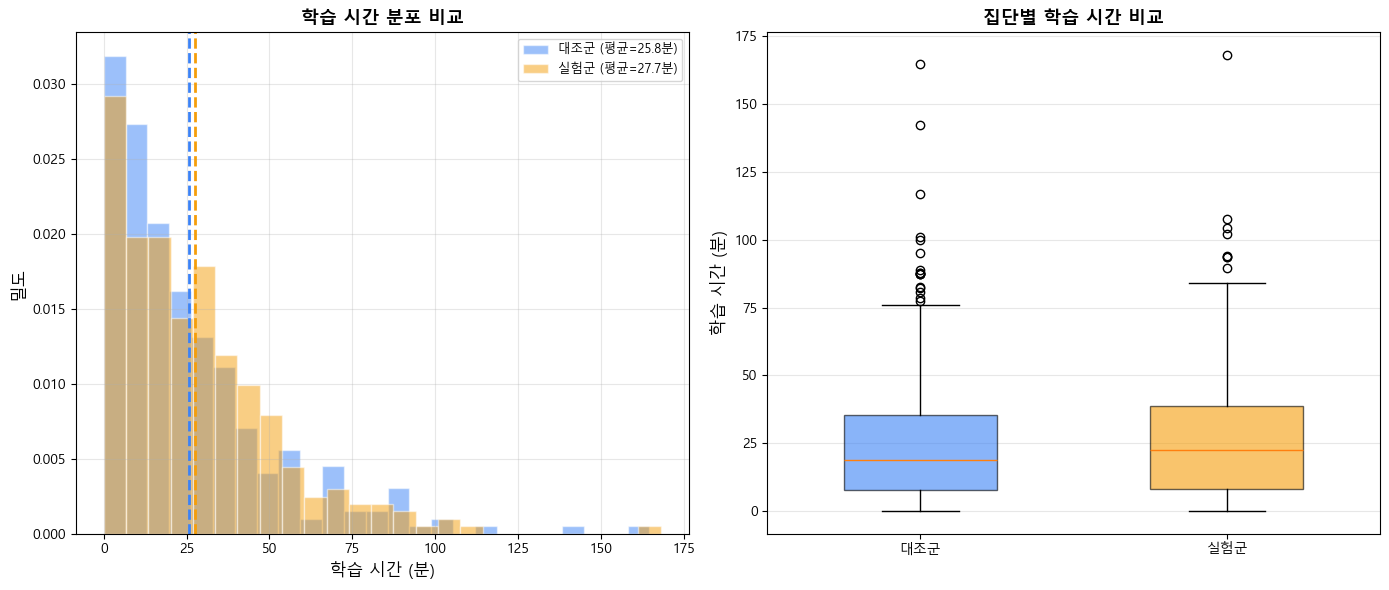

In [21]:
# 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(time_control, bins=25, alpha=0.5, color='#3B82F6', edgecolor='white',
             label=f'대조군 (평균={time_control.mean():.1f}분)', density=True)
axes[0].hist(time_treatment, bins=25, alpha=0.5, color='#F59E0B', edgecolor='white',
             label=f'실험군 (평균={time_treatment.mean():.1f}분)', density=True)
axes[0].axvline(time_control.mean(), color='#3B82F6', linestyle='--', linewidth=2)
axes[0].axvline(time_treatment.mean(), color='#F59E0B', linestyle='--', linewidth=2)
axes[0].set_xlabel('학습 시간 (분)', fontsize=12)
axes[0].set_ylabel('밀도', fontsize=12)
axes[0].set_title('학습 시간 분포 비교', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

bp = axes[1].boxplot([time_control, time_treatment],
                      labels=['대조군', '실험군'],
                      patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('#3B82F6')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('#F59E0B')
bp['boxes'][1].set_alpha(0.6)
axes[1].set_ylabel('학습 시간 (분)', fontsize=12)
axes[1].set_title('집단별 학습 시간 비교', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 4-1: 정규성 확인과 검정 방법 결정

**(a)** 각 집단의 **정규성 검정**(Shapiro-Wilk)을 수행하세요.

**(b)** 분포의 **왜도(skewness)** 를 계산하세요.

> `from scipy.stats import skew` → `skew(data)`

**(c)** 이 데이터에 t-검정을 적용할 수 있는지 판단하세요.
**중심극한정리(CLT)** 의 관점에서, 표본 크기(n=300)와 왜도를 함께 고려하여 설명하세요.

> | \|skew\| | 분류 | CLT 실무 기준 |
> |:--------:|:---:|:-------------|
> | < 0.5 | 거의 대칭 | n ≥ 15~20이면 충분 |
> | 0.5 ~ 1.0 | 중간 비대칭 | n ≥ 30 권장 |
> | > 1.0 | 강한 비대칭 | n ≥ 100+ 또는 비모수 고려 |

**(d)** 이 데이터에 사용할 **검정 방법**을 결정하세요.
모수 검정(Welch's t)과 비모수 검정(Mann-Whitney U) 중 어떤 것이 적절한지,
또는 **둘 다 수행하여 비교**하는 것이 좋은지 근거를 제시하세요.

In [22]:
print("\n[문제 4-1] 정규성 확인과 검정 방법 결정")
print("-" * 40)

# TODO (a): 정규성 검정
for name, data in [('대조군', time_control), ('실험군', time_treatment)]:
    stat, p = stats.shapiro(data)
    print(f"{name} 정규성 검정: W={stat:.4f}, p={p} -> {'정규성 만족' if p > 0.05 else '정규성 불만족'}")

# TODO (b): 왜도
from scipy.stats import skew
skew_control = skew(time_control)
skew_treatment = skew(time_treatment)
print(f"\n왜도 (Skewness):")
print(f"  대조군: {skew_control:.4f} -> {'대칭' if abs(skew_control) < 0.5 else '약한 왜도' if abs(skew_control) < 1 else '강한 왜도'}")
print(f"  실험군: {skew_treatment:.4f} -> {'대칭' if abs(skew_treatment) < 0.5 else '약한 왜도' if abs(skew_treatment) < 1 else '강한 왜도'}")  

# TODO (c): CLT 판단
print(f"가능하다. 데이터가 강한 비대칭을 보이지만, 현재 표본 크기가 300명으로 충분히 크다. CLT에 따르면 표본 크기가 충분히 크면, 표본 평균의 분포는 정규분포에 근사하기에 t-검정의 결과는 통계적으로 유효하다.")

# TODO (d): 검정 방법 결정
print(f"둘 다 수행하는 것이 가장 좋다. 두 검정으 결과가 일치한다면 결론의 신뢰도가 매우 높아지기 때문.")


[문제 4-1] 정규성 확인과 검정 방법 결정
----------------------------------------
대조군 정규성 검정: W=0.8258, p=1.0919848182888917e-17 -> 정규성 불만족
실험군 정규성 검정: W=0.8786, p=1.1314906014612684e-14 -> 정규성 불만족

왜도 (Skewness):
  대조군: 1.8458 -> 강한 왜도
  실험군: 1.5407 -> 강한 왜도
가능하다. 데이터가 강한 비대칭을 보이지만, 현재 표본 크기가 300명으로 충분히 크다. CLT에 따르면 표본 크기가 충분히 크면, 표본 평균의 분포는 정규분포에 근사하기에 t-검정의 결과는 통계적으로 유효하다.
둘 다 수행하는 것이 가장 좋다. 두 검정으 결과가 일치한다면 결론의 신뢰도가 매우 높아지기 때문.


### 문제 4-2: 검정 수행 및 효과크기

**(a)** **Welch's t-검정**을 수행하세요 (pingouin의 `pg.ttest()` 사용).

> `pg.ttest(x, y, alternative='two-sided')` → T, p-val, cohen-d, CI95%, BF10, power 제공

**(b)** **Mann-Whitney U 검정**을 수행하세요 (pingouin의 `pg.mwu()` 사용).

> `pg.mwu(x, y, alternative='two-sided')` → U-val, p-val, RBC, CLES 제공

**(c)** 두 검정의 결과를 비교하세요. 결론이 같은가요, 다른가요?
왜 같은/다른 결론이 나오는지 데이터의 특성(분포, 표본 크기)과 연결하여 설명하세요.

**(d)** 검정 결과를 종합하여, 게이미피케이션 도입의 효과에 대한 최종 결론을 내리세요.
통계적 유의성, 효과크기, 상대적 개선율을 모두 포함하세요.

In [23]:
print("\n[문제 4-2] 검정 수행 및 효과크기")
print("-" * 40)

# TODO (a): Welch's t-검정 (pingouin)
ttest_result = pg.ttest(time_treatment, time_control, alternative='two-sided')
display(ttest_result)

# TODO (b): Mann-Whitney U 검정 (pingouin)
mwu_result = pg.mwu(time_treatment, time_control, alternative='two-sided')
display(mwu_result)

# TODO (c): 두 검정 비교
print("두 검정 모두 p-value가 유의수준 0.05보다 크다. 따라서, 두 검정 모두 '게이미피케이션 도입이 학습시간을 늘렸다고 볼 수 없다'는 결론을 내린다.")
# TODO (d): 최종 결론
print("[통계적 유의성]p>0.05로 집단간 평균 차이가 우연에 의해 발생했을 가능성을 배제할 수 없으며,")
print("[효과크기] Cohen's d=0.075로 매우 작다. 이는 두 집단 간의 학습 시간 차이가 실질적으로 거의 없음을 의미하며,")
print("[상대적 개선율] 소폭 상승이 관찰되었으나, 통계적 근거가 부족하다.")
print("\n [최종 결정]:현재의 게이미피케이션 기능은 전체 사용자에게 배포하기에 부적절하다.")


[문제 4-2] 검정 수행 및 효과크기
----------------------------------------


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.919348,598,two-sided,0.358284,"[-2.1, 5.81]",0.075064,0.137,0.150687


,U-val,alternative,p-val,RBC,CLES
MWU,48086.5,two-sided,0.14607,0.068589,0.534294


두 검정 모두 p-value가 유의수준 0.05보다 크다. 따라서, 두 검정 모두 '게이미피케이션 도입이 학습시간을 늘렸다고 볼 수 없다'는 결론을 내린다.
[통계적 유의성]p>0.05로 집단간 평균 차이가 우연에 의해 발생했을 가능성을 배제할 수 없으며,
[효과크기] Cohen's d=0.075로 매우 작다. 이는 두 집단 간의 학습 시간 차이가 실질적으로 거의 없음을 의미하며,
[상대적 개선율] 소폭 상승이 관찰되었으나, 통계적 근거가 부족하다.

 [최종 결정]:현재의 게이미피케이션 기능은 전체 사용자에게 배포하기에 부적절하다.
